# Evaluate the enrichment of Decipher shared phenotype patients on our ASD-CHD interactome

Update 19-12-12: found all damaging SNVs/indels in DECIPHER, by looking up karyotype for abnormal nervous and cardiovascular systems.  Use this to make an ROC curve

Update 20-04-28: make sure results can be replicated from supplemental tables, add more description

Update 21-04-19: update for consistency with revision

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
import random


# latex rendering of text in graphs
import matplotlib as mpl
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

sns.set_style('white')

import sys

% matplotlib inline

sns.set_style("ticks", {"xtick.major.size": 15, "ytick.major.size": 15})
plt.rcParams['svg.fonttype'] = 'none'

# Load the ASD-CHD network genes, (z_ASD-CHD>=3; 844 genes)

In [2]:
ASD_CHD_df = pd.read_excel('data/supplemental_tables_cell_systems_210416.xlsx',
                           sheet_name='Table S5',skiprows=1)
ASD_CHD_df.index=ASD_CHD_df['gene']
print(len(ASD_CHD_df))
display(ASD_CHD_df.head())

844


,gene,ASD_seed,CHD_seed,dual_phenotype_snv_indel_DECIPHERv11.1,dual_phenotype_small_CNV_less1MB_DECIPHERv11.1,PCGC/PHN dual phenotype dDNV,"sum_dual_pheno_damaging_variants (DECIPHER 11.1, PCGC/PHN)",z_both
gene,,,,,,,,
KMT2A,KMT2A,0,1,17.0,1.0,1.0,19,52.658388
KANSL1,KANSL1,0,0,3.0,14.0,1.0,18,7.389539
CDK13,CDK13,0,1,15.0,1.0,0.0,16,65.097038
PTPN11,PTPN11,0,1,14.0,0.0,1.0,15,3.995214
ANKRD11,ANKRD11,0,0,14.0,1.0,0.0,15,3.766040


In [4]:
# number of dual-phenotype genes harboring at least one damaging variant (from DECIPHER v9.25, SNVs/INDELS/smallCNVs, + PCGC/PHN dual-phenotype dDNVs)
# but MLL2 is included here... set to nan because it is a duplicate of KMT2A in PCnet
sum(ASD_CHD_df['sum_dual_pheno_damaging_variants (DECIPHER 11.1, PCGC/PHN)']>0)

190

# Load the DECIPHER all dual-condition results

DECIPHER all dual-condition results come from DECIPHER v11.1 (manually aqcuired from the webtool), and include only  SNVs/indels which were classified as likely LOF or protein changing. We were not able to collect comprehensive CNV information from the DECIPHER webtool.


In [5]:
# dec_kary_shared = pd.read_excel('data/DECIPHER_karyotypes_9.31.xlsx',sheet_name='ASD-CHD')
# dec_kary_shared = pd.read_excel('/Users/brinrosenthal/Google Drive/UCSD/CCBB_tickets/Ideker_17_05_neuro/manuscript/tables_19_01/DECIPHER_karyotypes_210129.xlsx',
#                                sheet_name = 'ASD-CHD_210129')

# dec_kary_shared = pd.read_excel('/Users/brinrosenthal/Google Drive/UCSD/CCBB_tickets/Ideker_17_05_neuro/manuscript/CELL_SYSTEMS/supplemental_tables_cell_systems_210212.xlsx',
#                            sheet_name='DECIPHER_11.1_DETAILED')

dec_kary_shared = pd.read_excel('data/supplemental_tables_cell_systems_210416.xlsx',
                           sheet_name='Table S6',skiprows=1)

dec_kary_shared.index=dec_kary_shared['gene']
dec_kary_shared = dec_kary_shared.fillna(0)
dec_kary_shared['num_LOF_PC']=dec_kary_shared['num_likely_LOF']+dec_kary_shared['num_PC']
print(dec_kary_shared['num_LOF_PC'].sum())
print(len(dec_kary_shared))
dec_kary_shared.head()

911.0
437


,chr,gene,num_SNVs_indels,num_likely_LOF,num_PC,num_annotated_reg_region,num_UTR,num_ncRNA,num_other,num_LOF_PC
gene,,,,,,,,,,
GNB1,1,GNB1,1,0.0,1.0,0.0,0.0,0.0,0.0,1.0
CAMTA1,1,CAMTA1,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0
RERE,1,RERE,3,0.0,3.0,0.0,0.0,0.0,0.0,3.0
MTHFR,1,MTHFR,1,0.0,1.0,0.0,0.0,0.0,0.0,1.0
MTOR,1,MTOR,1,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [7]:
print(len(dec_kary_shared))
print(sum(dec_kary_shared['num_LOF_PC']))
print(sum(dec_kary_shared['num_LOF_PC']>1))

437
911.0
191


Text(0,0.5,'# dual-phenotype variants')

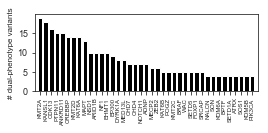

In [8]:
# bar-plot genes harboring most variants
# sns.set_style('whitegrid')
sns.set_style("ticks", {"xtick.major.size": 15, "ytick.major.size": 15})
# dual_plot =ASD_CHD_df[ASD_CHD_df['sum_damaging_variants (DECIPHER 9.25, PCGC/PHN)']>3]['sum_damaging_variants (DECIPHER 9.25, PCGC/PHN)']
dual_plot =ASD_CHD_df[ASD_CHD_df['sum_damaging_variants (DECIPHER 11.1, PCGC/PHN)']>3]['sum_damaging_variants (DECIPHER 11.1, PCGC/PHN)']
dual_plot=dual_plot.sort_values(ascending=False)
plt.figure(figsize=(4,1.41))
plt.bar(np.arange(len(dual_plot)),dual_plot,color='black')
tmp=plt.xticks(np.arange(len(dual_plot)),dual_plot.index.tolist(),fontsize=6,rotation='vertical',va='top')
plt.xlim([-1,len(dual_plot)])
plt.yticks([0,5,10,15],fontsize=9)
plt.ylabel('# dual-phenotype variants',fontsize=8)

# plt.savefig('/Users/brinrosenthal/Google Drive/UCSD/CCBB_tickets/Ideker_17_05_neuro/manuscript/figures_revisions_2102/Figure3/barchart_dualpheno_g2_11.1.png',dpi=300,bbox_inches='tight')
# plt.savefig('/Users/brinrosenthal/Google Drive/UCSD/CCBB_tickets/Ideker_17_05_neuro/manuscript/figures_revisions_2102/Figure3/barchart_dualpheno_g2_11.1.svg',dpi=300,bbox_inches='tight')

# plt.savefig('../../manuscript/figures_1911/Figure3/Figure3_final assets/barchart_dualpheno_g2.png',dpi=300,bbox_inches='tight')
# plt.savefig('../../manuscript/figures_1911/Figure3/Figure3_final assets/barchart_dualpheno_g2.svg',dpi=300,bbox_inches='tight',)
# plt.savefig('../../manuscript/figures_1911/Figure3/barchart_dualpheno_g2.svg',dpi=300,bbox_inches='tight')


In [9]:
dual_plot

gene
KMT2A      19
KANSL1     18
CDK13      16
PTPN11     15
ANKRD11    15
CREBBP     14
KMT2D      14
KAT6A      14
MAPT       13
NSD1       10
ARID1B     10
NF1        10
EHMT1      10
EP300       9
DYRK1A      8
MED13L      8
CHD7        7
CHD4        7
NOTCH1      7
ADNP        7
MECP2       6
ZEB2        6
KAT6B       5
POGZ        5
KMT2C       5
BRAF        5
WAC         5
SETD5       5
FOXP1       5
SRCAP       5
NALCN       4
SON         4
KDM6A       4
BPTF        4
SETD1A      4
ATRX        4
SOS1        4
KDM5B       4
PIK3CA      4
Name: sum_damaging_variants (DECIPHER 11.1, PCGC/PHN), dtype: int64

# DECIPHER ROC curves

In [10]:
# load the full z-score results for ASD and CHD

num_reps = 5000
focal_interactome='PCnet'
rand_method = 'degree_binning' # can be 'degree_binning' or 'degree_ks_test' (deprecated)

z_ASD = pd.read_csv('data/z_score_results/z_ASD_'+str(num_reps)+'_reps'+focal_interactome+'_'+rand_method+'.tsv',
                sep='\t',names=['gene','zscore'],index_col='gene')
z_CHD = pd.read_csv('data/z_score_results/z_CHD_'+str(num_reps)+'_reps'+focal_interactome+'_'+rand_method+'.tsv',
                       sep='\t',names=['gene','zscore'],index_col='gene')

# z_ASD = z_ASD['zscore'].copy()
# z_CHD = z_CHD['zscore'].copy()

z_ASD.head()

# multiply by the sign (+1 if both +, -1 if either -). 
z_ASDCHD = z_ASD['zscore'].abs()*z_CHD['zscore'].abs()*(((np.sign(z_ASD['zscore'])>0)&(np.sign(z_CHD['zscore'])>0))*1.0-.5)*2


z_ASDCHD.head()



seed_genes = ASD_CHD_df[(ASD_CHD_df['ASD_seed']==1)|(ASD_CHD_df['CHD_seed']==1)].index.tolist()
print(len(seed_genes))
non_seed_genes = list(np.setdiff1d(z_ASDCHD.index.tolist(),seed_genes))
z_ASDCHD_noseeds = z_ASDCHD.loc[non_seed_genes]
print(len(z_ASDCHD_noseeds))
z_ASDCHD_noseeds.max()

z_comb = z_ASD.join(z_CHD,lsuffix='_ASD',rsuffix='_CHD')
z_comb['zprod_both']=z_ASDCHD
z_comb.head()

z_comb_no_seeds = z_comb.loc[non_seed_genes]
z_comb_no_seeds.head()

80
19701


,zscore_ASD,zscore_CHD,zprod_both
gene,,,
A1BG,-1.483328,0.316803,-0.469922
A1CF,-0.927115,0.571386,-0.529741
A2M,-2.837494,0.598259,-1.697556
A2ML1,-1.119579,1.554647,-1.740550
A3GALT2,-0.807590,3.459356,-2.793741


In [11]:
focal_genes_temp = list(np.intersect1d(z_ASDCHD[z_ASDCHD>3].index.tolist(),dec_kary_shared.index.tolist()))
print(len(focal_genes_temp))
print(dec_kary_shared['num_LOF_PC'].loc[focal_genes_temp].dropna().sum())


94
334.0


In [12]:


def calc_FPR_TPR(z_ASDCHD, both_DECIPHER,thresh_list):

    TP_both_list,FP_both_list,TN_both_list,FN_both_list = [],[],[],[]

#     thresh_list = np.arange(0,30)
#     thresh_list = np.linspace(-17,400,1000)
#     thresh_list = np.linspace(0,2,1000)
    for thresh_temp in thresh_list:

        both_predicted = z_ASDCHD[z_ASDCHD>=thresh_temp].index.tolist()

        # ------ both -------
        num_TP_both = len(np.intersect1d(both_DECIPHER,both_predicted))
        num_FP_both = len(both_predicted)-num_TP_both
        num_FN_both = len(both_DECIPHER)-num_TP_both
        # number true negatives is everything that wasn't TP, FN, or FP
        num_TN_both = len(z_ASDCHD)-num_TP_both-num_FP_both-num_FN_both 

        TP_both_list.append(num_TP_both)
        FP_both_list.append(num_FP_both)
        TN_both_list.append(num_TN_both)
        FN_both_list.append(num_FN_both)

        # P is number of true positives in the data
        P_both = len(both_DECIPHER)
        # N is number of true negatives in the data (# number of interactome genes- P..?)
        N_both = len(z_ASDCHD)-P_both 
        # (TPR = sensitivity/ recall)
        TPR_both = np.divide(TP_both_list,float(P_both))
        FPR_both = np.divide(FP_both_list,float(N_both))

        
    return(TPR_both,FPR_both)

In [14]:
# make an ROC curve sweeping z score
from sklearn.metrics import roc_curve,auc
thresh_list = np.linspace(-17,400,2000)

# -------- set threshold for number of variants observed per gene (1 used in main text, 0 used in supplement ) --------
dec_thresh=1 
# ------------------------------------------------

both_DECIPHER = dec_kary_shared[dec_kary_shared['num_LOF_PC']>dec_thresh].index.tolist()
print(len(both_DECIPHER))
# make sure the genes are able to be recovered
both_DECIPHER = list(np.intersect1d(z_ASDCHD.index.tolist(),both_DECIPHER))
print(len(both_DECIPHER))

TPR_both,FPR_both=calc_FPR_TPR(z_comb['zprod_both'], both_DECIPHER,thresh_list)

both_DECIPHER_noseeds = list(np.setdiff1d(both_DECIPHER,seed_genes))
print(len(both_DECIPHER_noseeds))
TPR_both_noseeds,FPR_both_noseeds=calc_FPR_TPR(z_comb_no_seeds['zprod_both'], both_DECIPHER_noseeds,thresh_list)
# TPR_both

auc_both = auc(FPR_both,TPR_both)
print('\nAUC all:')
print(auc_both)
auc_both_noseeds = auc(FPR_both_noseeds,TPR_both_noseeds)
print('\nAUC seeds excluded:')
print(auc_both_noseeds)



auc_both_rand=[]
# randomize xeno_df
for r in np.arange(100):
#     print(r)
    if (r%10)==0:
        print(r)

    z_ASDrand = z_ASD.copy(deep=True)
    rand_index=z_ASDrand.index.tolist()
    np.random.shuffle(rand_index)
    z_ASDrand.index=rand_index
    z_CHDrand = z_CHD.copy(deep=True)
    rand_index=z_CHDrand.index.tolist()
    np.random.shuffle(rand_index)
    z_CHDrand.index=rand_index
    z_ASDrand.head()

    z_ASDCHDrand = z_ASDrand['zscore'].abs()*z_CHDrand['zscore'].abs()*(((np.sign(z_ASDrand['zscore'])>0)&(np.sign(z_CHDrand['zscore'])>0))*1.0-.5)*2

    
    TPR_both_rand,FPR_both_rand=calc_FPR_TPR(z_ASDCHDrand, both_DECIPHER,thresh_list)
    auc_both_rand.append(auc(TPR_both_rand,FPR_both_rand))

    
print(np.mean(auc_both_rand))



191
186
160

AUC all:
0.7048441971426768

AUC seeds excluded:
0.6591106519625403
0


KeyboardInterrupt: 

11.483111070490256
8.020149377308533e-31
9.504023449205095
1.0096687025639668e-21


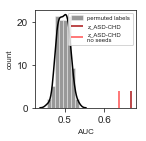

In [28]:
from scipy.stats import norm
sns.set_style('white')
sns.set_style("ticks", {"xtick.major.size": 15, "ytick.major.size": 15})
# from scipy.special import ndtr
plt.figure(figsize=(1.8,1.8))
sns.distplot(auc_both_rand,label='permuted labels',color='k')
z_both = (auc_both-np.mean(auc_both_rand))/np.std(auc_both_rand)
print(z_both)
print(norm.sf(z_both))
z_both_noseeds = (auc_both_noseeds-np.mean(auc_both_rand))/np.std(auc_both_rand)
print(z_both_noseeds)
print(norm.sf(z_both_noseeds))
plt.vlines(auc_both,0,4,color='#A81012',label='z_ASD-CHD')
plt.vlines(auc_both_noseeds,0,4,color='#FF4F4F',label='z_ASD-CHD\nno seeds')
plt.legend(loc='upper right',fontsize=6)
plt.xlabel('AUC',fontsize=8)
plt.ylabel('count',fontsize=8)
# plt.savefig('../../manuscript/figures_1911/Supplement/DECIPHER_SNV_INDEL_AUC_'+str(dec_thresh)+'.png',dpi=300,bbox_inches='tight')
# plt.savefig('../../manuscript/figures_1911/Supplement/DECIPHER_SNV_INDEL_AUC_'+str(dec_thresh)+'.svg',dpi=300,bbox_inches='tight')

# plt.savefig('/Users/brinrosenthal/Google Drive/UCSD/CCBB_tickets/Ideker_17_05_neuro/manuscript/figures_revisions_2102/Figure3/DECIPHER_11.1_SNV_INDEL_AUC_'+str(dec_thresh)+'.png',dpi=300,bbox_inches='tight')
# plt.savefig('/Users/brinrosenthal/Google Drive/UCSD/CCBB_tickets/Ideker_17_05_neuro/manuscript/figures_revisions_2102/Figure3/DECIPHER_11.1_SNV_INDEL_AUC_'+str(dec_thresh)+'.svg',dpi=300,bbox_inches='tight')


,FPR_both,FPR_both_noseeds,FPR_both_rand,TPR_both,TPR_both_noseeds,TPR_both_rand,thresh
96,0.038223,0.036032,0.019576,0.220903,0.148052,0.014252,3.026013


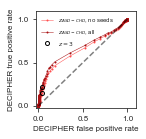

In [29]:
from sklearn.metrics import roc_curve,auc
sns.set_style('white')
sns.set_style("ticks", {"xtick.major.size": 15, "ytick.major.size": 15})
threshlist = np.linspace(-17,400,2000)
ROC_df = pd.DataFrame({'thresh':threshlist,
                      'FPR_both':FPR_both,'TPR_both':TPR_both,
                      'FPR_both_noseeds':FPR_both_noseeds,'TPR_both_noseeds':TPR_both_noseeds,
                      'FPR_both_rand':FPR_both_rand,'TPR_both_rand':TPR_both_rand})
ROC_df.head()
plt.figure(figsize=(1.8,1.8))
plt.plot(FPR_both_noseeds,TPR_both_noseeds,'.-',color='#FF4F4F',label='$z_{ASD-CHD}$, no seeds',lw=.5,ms=2)
plt.plot(FPR_both,TPR_both,'.-',color='#A81012',label='$z_{ASD-CHD}$, all',lw=.5,ms=2)


# circle z=3 
ROC_z3 = ROC_df[(ROC_df['thresh']>2.9)&(ROC_df['thresh']<3.1)]
display(ROC_z3)
plt.plot(ROC_z3['FPR_both'],ROC_z3['TPR_both'],'o',ms=4,color='k',fillstyle='none',label='$z=3$')
plt.plot(ROC_z3['FPR_both_noseeds'],ROC_z3['TPR_both_noseeds'],'o',ms=4,color='k',fillstyle='none',label='')

# plt.plot(FPR_both_rand,TPR_both_rand,'k.-')
plt.plot([0,1],[0,1],'k--',alpha=.5)
plt.legend(loc='upper left', fontsize=6,frameon=False)
plt.xlabel('DECIPHER false positive rate',fontsize=8)
plt.ylabel('DECIPHER true positive rate',fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.xlim([-.03,1.1])
plt.ylim([-.03,1.1])

# plt.savefig('/Users/brinrosenthal/Google Drive/UCSD/CCBB_tickets/Ideker_17_05_neuro/manuscript/figures_revisions_2102/Figure3/DECIPHER_11.1_SNV_INDEL_ROC_'+str(dec_thresh)+'.png',dpi=300,bbox_inches='tight')
# plt.savefig('/Users/brinrosenthal/Google Drive/UCSD/CCBB_tickets/Ideker_17_05_neuro/manuscript/figures_revisions_2102/Figure3/DECIPHER_11.1_SNV_INDEL_ROC_'+str(dec_thresh)+'.svg',dpi=300,bbox_inches='tight')

